In [42]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as f
import matplotlib.pyplot as plt
import torch.optim as optim
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import classification_report

In [2]:
#dataset url : https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset
df = pd.read_csv("diabetes_prediction_dataset.csv")
df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,Female,80.0,0,0,No Info,27.32,6.2,90,0
99996,Female,2.0,0,0,No Info,17.37,6.5,100,0
99997,Male,66.0,0,0,former,27.83,5.7,155,0
99998,Female,24.0,0,0,never,35.42,4.0,100,0


In [3]:
columns = [
    "gender",
    "age",
    "hypertension",
    "heart_disease",
    "smoking_history",
    "bmi",
    "HbA1c_level",
    "blood_glucose_level",
    "diabetes",
    ]
diabetes_data = df.dropna(subset=columns)
diabetes_data

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,Female,80.0,0,0,No Info,27.32,6.2,90,0
99996,Female,2.0,0,0,No Info,17.37,6.5,100,0
99997,Male,66.0,0,0,former,27.83,5.7,155,0
99998,Female,24.0,0,0,never,35.42,4.0,100,0


In [4]:
diabetes_data = diabetes_data.drop(diabetes_data[diabetes_data['smoking_history'] == 'No Info'].index)
diabetes_data['smoking_history'] = diabetes_data['smoking_history'].apply(lambda x: 1 if x == 'current' else (0.5 if x == 'former' else 0))
diabetes_data['gender'] = diabetes_data['gender'].apply(lambda x: 1 if x == 'Female' else 0)
diabetes_data

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,1,80.0,0,1,0.0,25.19,6.6,140,0
2,0,28.0,0,0,0.0,27.32,5.7,158,0
3,1,36.0,0,0,1.0,23.45,5.0,155,0
4,0,76.0,1,1,1.0,20.14,4.8,155,0
5,1,20.0,0,0,0.0,27.32,6.6,85,0
...,...,...,...,...,...,...,...,...,...
99992,1,26.0,0,0,0.0,34.34,6.5,160,0
99993,1,40.0,0,0,0.0,40.69,3.5,155,0
99997,0,66.0,0,0,0.5,27.83,5.7,155,0
99998,1,24.0,0,0,0.0,35.42,4.0,100,0


<Axes: >

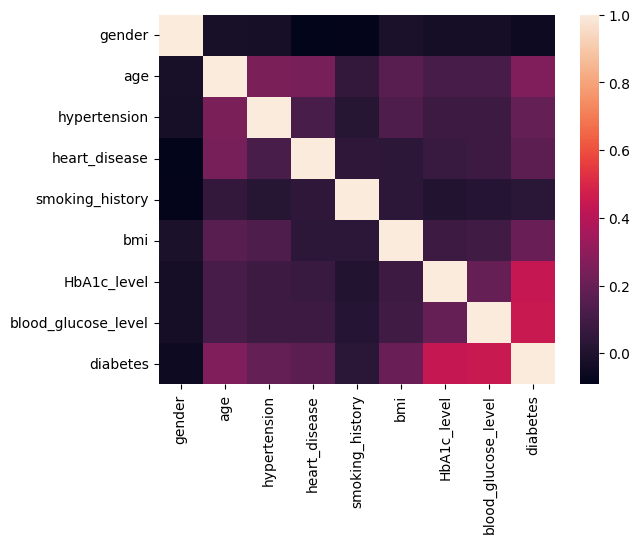

In [5]:
correlation = diabetes_data.corr()
sns.heatmap(correlation)

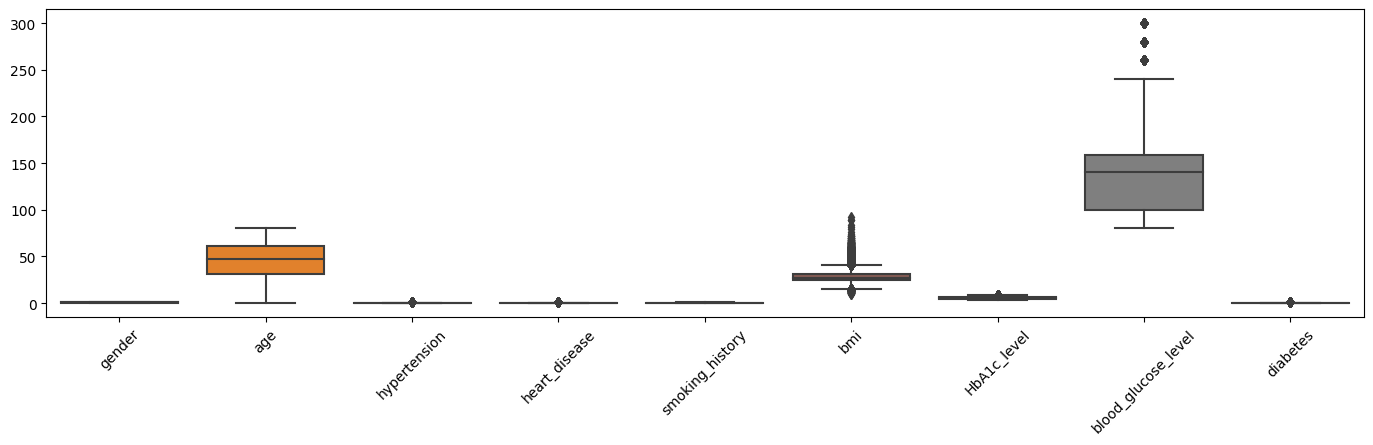

In [6]:
fig, ax = plt.subplots(1, figsize=(17, 4))
ax = sns.boxplot(data=diabetes_data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

In [7]:
#normalize data into z score
colszscore = diabetes_data.keys()
colszscore = colszscore.drop('diabetes')

for col in colszscore:
  meanval = np.mean(diabetes_data[col])
  stdev = np.std(diabetes_data[col], ddof=1)
  diabetes_data[col] = (diabetes_data[col] - meanval) / stdev

diabetes_data.describe()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
count,6.418400e+04,6.418400e+04,6.418400e+04,6.418400e+04,6.418400e+04,6.418400e+04,6.418400e+04,6.418400e+04,64184.000000
mean,1.638420e-17,-2.878305e-16,3.597881e-17,-6.752946e-17,-5.933736e-17,7.417170e-17,-2.716677e-16,1.036190e-16,0.109778
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.312615
min,-1.238422e+00,-2.373762e+00,-3.294103e-01,-2.221655e-01,-5.947224e-01,-2.815156e+00,-1.884294e+00,-1.414134e+00,0.000000
25%,-1.238422e+00,-7.954885e-01,-3.294103e-01,-2.221655e-01,-5.947224e-01,-5.868636e-01,-6.976425e-01,-9.398168e-01,0.000000
50%,8.074668e-01,2.333062e-02,-3.294103e-01,-2.221655e-01,-5.947224e-01,-1.694423e-01,2.151666e-01,8.816956e-03,0.000000
75%,8.074668e-01,7.397974e-01,-3.294103e-01,-2.221655e-01,7.722617e-01,4.106504e-01,5.802903e-01,4.594180e-01,0.000000
max,8.074668e-01,1.712145e+00,3.035681e+00,4.501078e+00,2.139246e+00,9.728966e+00,3.136156e+00,3.803352e+00,1.000000


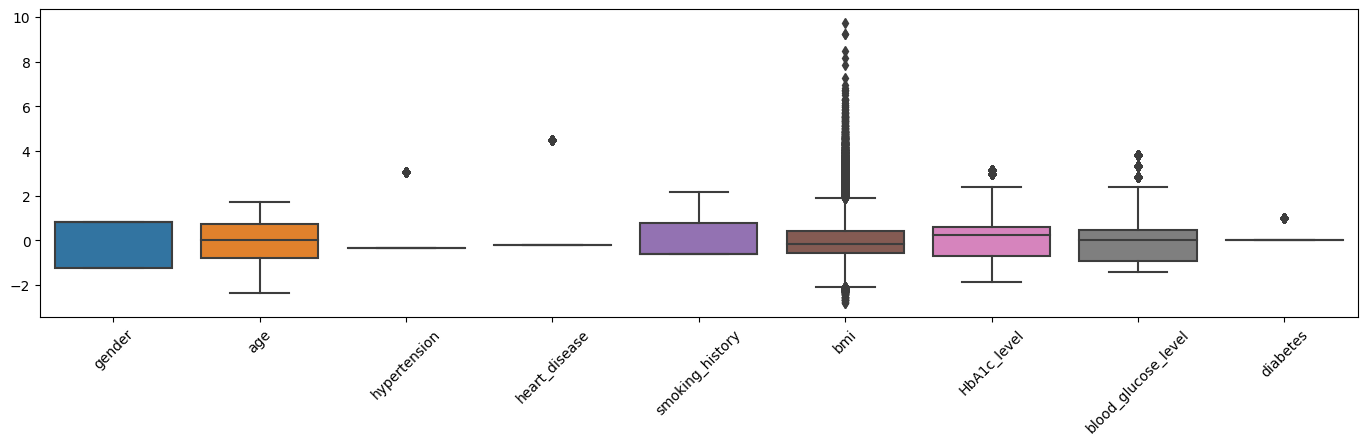

In [8]:
fig, ax = plt.subplots(1, figsize=(17, 4))
ax = sns.boxplot(data=diabetes_data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

In [15]:
dataT = torch.tensor(diabetes_data[colszscore].values).float()
labels = torch.tensor(diabetes_data['diabetes'].values).float()

print(dataT.shape)
print(labels.shape)

labels = labels.unsqueeze(1)
print(labels.shape)

torch.Size([64184, 8])
torch.Size([64184])
torch.Size([64184, 1])


In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(dataT, labels, test_size=0.2, random_state=42)
train_data = TensorDataset(X_train, Y_train)
test_data = TensorDataset(X_test, Y_test)

batchsize = 64
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [17]:
for X, y in train_loader:
  print(f'{X.shape}, {y.shape}')

torch.Size([64, 8]), torch.Size([64, 1])
torch.Size([64, 8]), torch.Size([64, 1])
torch.Size([64, 8]), torch.Size([64, 1])
torch.Size([64, 8]), torch.Size([64, 1])
torch.Size([64, 8]), torch.Size([64, 1])
torch.Size([64, 8]), torch.Size([64, 1])
torch.Size([64, 8]), torch.Size([64, 1])
torch.Size([64, 8]), torch.Size([64, 1])
torch.Size([64, 8]), torch.Size([64, 1])
torch.Size([64, 8]), torch.Size([64, 1])
torch.Size([64, 8]), torch.Size([64, 1])
torch.Size([64, 8]), torch.Size([64, 1])
torch.Size([64, 8]), torch.Size([64, 1])
torch.Size([64, 8]), torch.Size([64, 1])
torch.Size([64, 8]), torch.Size([64, 1])
torch.Size([64, 8]), torch.Size([64, 1])
torch.Size([64, 8]), torch.Size([64, 1])
torch.Size([64, 8]), torch.Size([64, 1])
torch.Size([64, 8]), torch.Size([64, 1])
torch.Size([64, 8]), torch.Size([64, 1])
torch.Size([64, 8]), torch.Size([64, 1])
torch.Size([64, 8]), torch.Size([64, 1])
torch.Size([64, 8]), torch.Size([64, 1])
torch.Size([64, 8]), torch.Size([64, 1])
torch.Size([64, 

In [18]:
class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()
    self.l1 = nn.Linear(8, 32)
    self.b1 = nn.BatchNorm1d(32)
    self.l2 = nn.ReLU()
    self.l3 = nn.Linear(32, 32)
    self.b2 = nn.BatchNorm1d(32)
    self.l4 = nn.ReLU()
    self.l5 = nn.Linear(32, 20)
    self.b3 = nn.BatchNorm1d(20)
    self.l6 = nn.ReLU()
    self.l7 = nn.Linear(20, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    y_hat = self.l1(x)
    y_hat = self.b1(y_hat)
    y_hat = self.l2(y_hat)
    y_hat = self.l3(y_hat)
    y_hat = self.b2(y_hat)
    y_hat = self.l4(y_hat)
    y_hat = self.l5(y_hat)
    y_hat = self.b3(y_hat)
    y_hat = self.l6(y_hat)
    y_hat = self.l6(y_hat)
    y_hat = self.l7(y_hat)
    return self.sigmoid(y_hat)

model = MyModel()
model

MyModel(
  (l1): Linear(in_features=8, out_features=32, bias=True)
  (b1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l2): ReLU()
  (l3): Linear(in_features=32, out_features=32, bias=True)
  (b2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l4): ReLU()
  (l5): Linear(in_features=32, out_features=20, bias=True)
  (b3): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l6): ReLU()
  (l7): Linear(in_features=20, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [19]:
class BackpropBatch:
  def __init__(self):
    self.batchloss = []
    self.batchAcc = []
    self.losses = []
    self.acc_train = []

  #train entire batch
  def train_model(self, model, n_epochs, train_loader: torch.utils.data.dataloader.DataLoader, lr=0.01):
    model.train()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for X, y in train_loader:
      for i in range(n_epochs):
        y_hat = model(X)
        optimizer.zero_grad()
        loss = criterion(y_hat, y)
        loss.backward()
        acc = 100*torch.mean(((y_hat >= 0.5) == y).float()).item()
        if (i + 1) % 10 == 0:
          self.batchloss.append(loss.item())
          self.batchAcc.append(acc)
          self.losses.append(np.mean(np.array(self.batchloss)))
        optimizer.step()
        if (i + 1) % 10 == 0:
          print(f"Epoch [{i+1}/{n_epochs}], Loss: {loss.item()}, accuracy model : {acc}")
      self.acc_train.append(acc)


  def get_losses(self):
    return torch.tensor(self.losses)
  def get_batchloss(self):
    return torch.tensor(self.batchloss)
  def get_acc_train(self):
    return torch.tensor(self.acc_train)

In [20]:
class EvalModel:
  def __init__(self, test_loader):
    self.test_loader = test_loader
    self.X, self.y = next(iter(test_loader))
    self.test_acc = []
    self.y_hat: torch.Tensor
  def eval(self, model):
    with torch.no_grad():
      for X, y in self.test_loader:
        y_hat = model(X)
        self.y_hat = y_hat
        self.test_acc.append(100*torch.mean(((y_hat >= 0.5) == y).float()).item())
        print(f'accuracy model in test dev : {100*torch.mean(((y_hat >= 0.5) == y).float()).item()}')
  def get_test_acc(self):
    return np.array(self.test_acc)
  def get_y_hat(self):
    return self.y_hat

In [21]:
bp = BackpropBatch()
bp.train_model(model, 1000, train_loader)


Streaming output truncated to the last 5000 lines.
Epoch [10/1000], Loss: 0.061232857406139374, accuracy model : 98.4375
Epoch [20/1000], Loss: 0.061224065721035004, accuracy model : 98.4375
Epoch [30/1000], Loss: 0.06121816113591194, accuracy model : 98.4375
Epoch [40/1000], Loss: 0.06121527776122093, accuracy model : 98.4375
Epoch [50/1000], Loss: 0.06121411174535751, accuracy model : 98.4375
Epoch [60/1000], Loss: 0.061213720589876175, accuracy model : 98.4375
Epoch [70/1000], Loss: 0.061213601380586624, accuracy model : 98.4375
Epoch [80/1000], Loss: 0.06121356412768364, accuracy model : 98.4375
Epoch [90/1000], Loss: 0.06121355667710304, accuracy model : 98.4375
Epoch [100/1000], Loss: 0.06121354550123215, accuracy model : 98.4375
Epoch [110/1000], Loss: 0.06121354177594185, accuracy model : 98.4375
Epoch [120/1000], Loss: 0.06121353060007095, accuracy model : 98.4375
Epoch [130/1000], Loss: 0.06121351942420006, accuracy model : 98.4375
Epoch [140/1000], Loss: 0.06121351569890976,

In [22]:
train_loss = bp.get_losses().numpy()
train_acc = bp.get_acc_train().numpy()

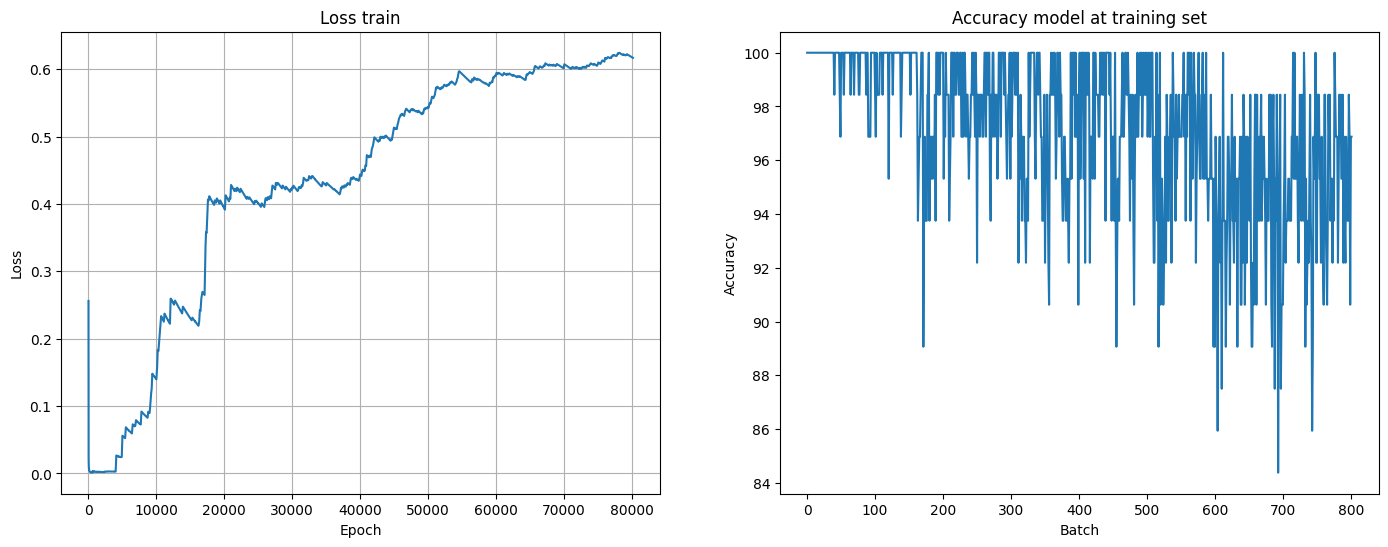

In [23]:
#TODO: continue this plotting loss train and loss test
fig, ax = plt.subplots(1, 2, figsize=(17, 6))
X = [x for x in range(len(train_loss))]
ax[0].plot(X, train_loss)
ax[0].set_title('Loss train')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].grid()

X1 = [x for x in range(len(train_acc))]

ax[1].plot(X1, train_acc)
ax[1].set_xlabel('Batch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy model at training set')

plt.show()

In [37]:
evalObj = EvalModel(test_loader)
evalObj.eval(model)
print(f'Accuracy Model : {evalObj.get_test_acc()}')

accuracy model in test dev : 94.75734233856201
Accuracy Model : [94.75734234]


In [38]:
test_y_hat = evalObj.get_y_hat()
acc_test = evalObj.get_test_acc()
print(f'{test_y_hat}')
print(f'{type(test_y_hat)}')

tensor([[2.5201e-13],
        [0.0000e+00],
        [1.0000e+00],
        ...,
        [0.0000e+00],
        [8.3333e-02],
        [8.3333e-02]])
<class 'torch.Tensor'>


In [39]:
X, y = next(iter(test_loader))
test_y_hat = torch.where(test_y_hat >= 0.5, 1, 0)
test_y_hat

tensor([[0],
        [0],
        [1],
        ...,
        [0],
        [0],
        [0]])

In [40]:
y

tensor([[0.],
        [0.],
        [1.],
        ...,
        [0.],
        [0.],
        [0.]])

In [41]:
report = classification_report(y.numpy(), test_y_hat.numpy())
print(report)

              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97     11415
         1.0       0.94      0.57      0.70      1422

    accuracy                           0.95     12837
   macro avg       0.94      0.78      0.84     12837
weighted avg       0.95      0.95      0.94     12837



In [26]:
torch.save(model.state_dict(), './model.pt')